In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(r'C:\Users\Sid\Downloads\archive\images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:\Users\Sid\Downloads\archive\images\0_2000.jpg
C:\Users\Sid\Downloads\archive\images\10000_2004.jpg
C:\Users\Sid\Downloads\archive\images\10001_2004.jpg
C:\Users\Sid\Downloads\archive\images\10002_2004.jpg
C:\Users\Sid\Downloads\archive\images\10003_2004.jpg
C:\Users\Sid\Downloads\archive\images\10004_2004.jpg
C:\Users\Sid\Downloads\archive\images\10005_2004.jpg
C:\Users\Sid\Downloads\archive\images\10006_2004.jpg
C:\Users\Sid\Downloads\archive\images\10007_2004.jpg
C:\Users\Sid\Downloads\archive\images\10008_2004.jpg
C:\Users\Sid\Downloads\archive\images\10009_2004.jpg
C:\Users\Sid\Downloads\archive\images\1000_2000.jpg
C:\Users\Sid\Downloads\archive\images\10010_2004.jpg
C:\Users\Sid\Downloads\archive\images\10011_2004.jpg
C:\Users\Sid\Downloads\archive\images\10012_2004.jpg
C:\Users\Sid\Downloads\archive\images\10013_2004.jpg
C:\Users\Sid\Downloads\archive\images\10014_2004.jpg
C:\Users\Sid\Downloads\archive\images\10015_2004.jpg
C:\Users\Sid\Downloads\archive\images\10016_2004.jp

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch import nn, optim
from matplotlib import pyplot as plt


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'CPU'
print(device)

cuda


In [4]:
path = r'C:\Users\Sid\Downloads\archive'
os.path.exists(path)

True

In [5]:
norm=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
batch_size = 64
image_size = 64

In [6]:
transf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*norm,inplace=True),
])

In [7]:
from torchvision import datasets

dataset = datasets.ImageFolder(root=path,transform=transf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [8]:
def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

In [9]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        unnorm_images = unnorm(images, *norm)
        ax.imshow(make_grid(unnorm_images[:batch_size], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

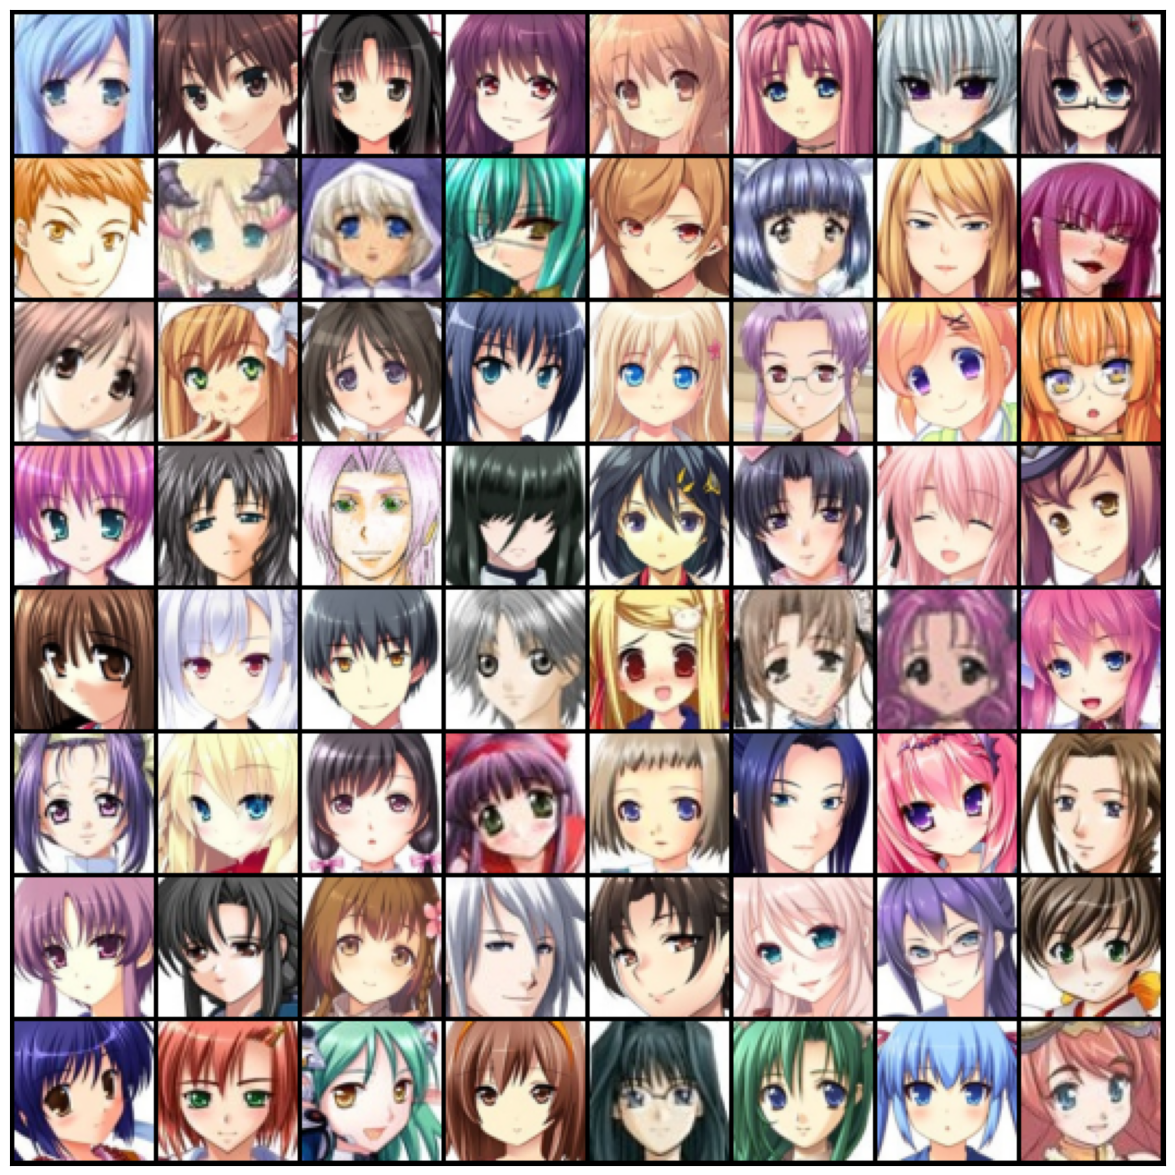

In [10]:
show_batch(dataloader)

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.in_dim = in_dim
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, channels, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)
        
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, width, height)
        
        out = self.gamma * out + x
        return out

In [13]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_d=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, feature_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention(feature_d),
            self._block(feature_d, feature_d * 2, 4, 2, 1),
            SelfAttention(feature_d * 2),
            self._block(feature_d * 2, feature_d * 4, 4, 2, 1),
            nn.Conv2d(feature_d * 4, 1, kernel_size=4, stride=1, padding=0),
            nn.Dropout(0.5),
            nn.Sigmoid()  
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        return self.net(x)


In [14]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, feature_g=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(z_dim, feature_g * 16, 4, 1, 0),  # input z_dim channels, output feature_g * 16
            SelfAttention(feature_g * 16),
            self._block(feature_g * 16, feature_g * 8, 4, 2, 1),
            SelfAttention(feature_g * 8),
            self._block(feature_g * 8, feature_g * 4, 4, 2, 1),
            SelfAttention(feature_g * 4),
            self._block(feature_g * 4, feature_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(feature_g * 2, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Outputs image with pixel values between -1 and 1
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        # Reshape the latent vector z to be of shape (batch_size, z_dim, 1, 1)
        x = x.view(x.size(0), -1, 1, 1)  # (batch_size, z_dim, 1, 1)
        return self.net(x)


In [15]:
num_epochs = 500

In [16]:
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision

lr_g = 2e-3
lr_d = 5e-5
z_dim = 100
img_size = 64
batch_size = 64
epochs = 20
save_interval = 5
image_save_dir = './generated_images'
checkpoint_dir = './checkpoints'

os.makedirs(image_save_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



gen = Generator(z_dim = z_dim).to(device)
disc = Discriminator().to(device)
gen.apply(weights_init)
disc.apply(weights_init)
optimizer_G = optim.Adam(gen.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=lr_d, betas=(0.5, 0.999))
criterion = nn.BCELoss()

def save_checkpoint(gen, disc, epoch, path):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': gen.state_dict(),
        'discriminator_state_dict': disc.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
    }, path)
    print(f"Model checkpoint saved at epoch {epoch}")

def save_generated_images(epoch, generator, fixed_noise, path):
    generator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
    fake_images = (fake_images + 1) / 2
    grid = np.transpose(torchvision.utils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0))
    plt.imshow(grid)
    plt.axis('off')
    plt.savefig(os.path.join(path, f'epoch_{epoch}.png'))
    plt.close()

fixed_noise = torch.randn(64, z_dim, 1, 1).to(device)

for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.size(0)
        
        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(z)
        disc_real = disc(real).view(-1)
        disc_fake = disc(fake.detach()).view(-1)
        loss_D_real = criterion(disc_real, torch.ones_like(disc_real))
        loss_D_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_D = (loss_D_real + loss_D_fake) / 2
        
        disc.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        
        output = disc(fake).view(-1)
        loss_G = criterion(output, torch.ones_like(output))
        
        gen.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_D:.4f}, Loss G: {loss_G:.4f}")
    
    if epoch % save_interval == 0 or epoch == epochs - 1:
        save_checkpoint(gen, disc, epoch, os.path.join(checkpoint_dir, f"SAGAN_epoch_{epoch}.pth"))
        save_generated_images(epoch, gen, fixed_noise, image_save_dir)

Epoch [0/20] Batch 0/994                   Loss D: 0.9600, Loss G: 1.0603
Epoch [0/20] Batch 100/994                   Loss D: 1.1844, Loss G: 0.7741
Epoch [0/20] Batch 200/994                   Loss D: 1.0553, Loss G: 0.7742
Epoch [0/20] Batch 300/994                   Loss D: 0.9549, Loss G: 0.8134
Epoch [0/20] Batch 400/994                   Loss D: 0.8741, Loss G: 0.8699
Epoch [0/20] Batch 500/994                   Loss D: 0.9244, Loss G: 0.7279
Epoch [0/20] Batch 600/994                   Loss D: 0.8467, Loss G: 0.7293
Epoch [0/20] Batch 700/994                   Loss D: 0.8232, Loss G: 0.7282
Epoch [0/20] Batch 800/994                   Loss D: 0.8044, Loss G: 0.7385
Epoch [0/20] Batch 900/994                   Loss D: 0.7918, Loss G: 0.7579
Model checkpoint saved at epoch 0
Epoch [1/20] Batch 0/994                   Loss D: 0.7672, Loss G: 0.7571
Epoch [1/20] Batch 100/994                   Loss D: 0.7764, Loss G: 0.7409
Epoch [1/20] Batch 200/994                   Loss D: 0.759

KeyboardInterrupt: 

Keyboard interrupt because results started to get noisy fairly quickly

In [25]:
torch.save(modelG.state_dict(), 'G.pth')
torch.save(modelD.state_dict(), 'D.pth')